In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
RANDOM_SEED = 42

In [14]:
!pip freeze > requirements.txt

In [15]:
df_train = pd.read_csv('main_task.xls')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [16]:
df_train['sample'] = 1
df_test['sample'] = 0
df_test['Rating'] = 0

In [17]:
data = df_test.append(df_train, sort=False).reset_index(drop=True)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [19]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
32082,id_12387,London,NaN,12397.0,NaN,NaN,"[['A Great Chinese takeaway in Leyton'], ['12/...",/Restaurant_Review-g186338-d4924950-Reviews-Fo...,d4924950,1,4.0
44383,id_3394,Lisbon,NaN,3398.0,NaN,NaN,"[[], []]",/Restaurant_Review-g189158-d2616613-Reviews-Pa...,d2616613,1,3.0
35942,id_3888,Berlin,NaN,3890.0,NaN,2.0,"[['Fast, friendly service'], ['09/29/2015']]",/Restaurant_Review-g187323-d5614678-Reviews-Pi...,d5614678,1,4.5
11015,id_129,Barcelona,"['Mediterranean', 'European', 'Spanish', 'Vege...",130.0,$$ - $$$,742.0,"[['My meeting point', 'Great black ink Paella'...",/Restaurant_Review-g187497-d10901576-Reviews-V...,d10901576,1,4.5
47043,id_2354,Madrid,"['Bar', 'Healthy']",2356.0,$$ - $$$,8.0,"[['Good', 'Culinary Delight'], ['12/26/2017', ...",/Restaurant_Review-g187514-d11981861-Reviews-U...,d11981861,1,5.0


In [26]:
data['Number_of_Reviews_is_NAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
data['Number of Reviews'].fillna(0, inplace=True)

In [27]:
data['Cuisine_Style_is_NAN'] = pd.isna(data['Cuisine Style']).astype('uint8')
data['Cuisine Style'].fillna('Undefined', inplace=True)

In [28]:
data['Price_Range_is_NAN'] = pd.isna(data['Price Range']).astype('uint8')
data['Price Range'].fillna(0, inplace=True)

In [29]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_is_NAN,Cuisine_Style_is_NAN,Price_Range_is_NAN
37926,id_1875,Lisbon,"['European', 'Portuguese']",1878.0,$,9.0,"[['Great food at great prices!', 'Real local L...",/Restaurant_Review-g189158-d4162697-Reviews-O_...,d4162697,1,4.5,0,0,0
23465,id_1965,Warsaw,Undefined,1967.0,0,0.0,"[['ok for lunch'], ['09/24/2015']]",/Restaurant_Review-g274856-d8665104-Reviews-To...,d8665104,1,3.0,0,1,1
28644,id_2432,Prague,"['European', 'Czech']",2437.0,0,6.0,"[['Good seasonal menu'], ['10/23/2014']]",/Restaurant_Review-g274707-d4768600-Reviews-Ve...,d4768600,1,4.5,0,0,1
38214,id_11267,Paris,['Italian'],11269.0,$,24.0,"[['Really nice friendly and helpful staff!', '...",/Restaurant_Review-g187147-d1057239-Reviews-Le...,d1057239,1,3.5,0,0,0
32152,id_3622,Lisbon,Undefined,3627.0,0,9.0,"[[], []]",/Restaurant_Review-g189158-d5977345-Reviews-Vi...,d5977345,1,2.0,0,1,1


In [32]:
data['Price Range'].mask(data['Price Range'] == '$', 1, inplace=True)
data['Price Range'].mask(data['Price Range'] == '$$ - $$$', 2, inplace=True)
data['Price Range'].mask(data['Price Range'] == '$$$$', 3, inplace=True)
data['Price Range'].mask(data['Price Range'] == 0, 2, inplace=True)

In [33]:
data = pd.get_dummies(data, columns=['City'], dummy_na=True)

In [34]:
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: ['other_style'] if pd.isnull(x) else x[1:-1].split(',') )
data['cuisine_counts'] = data['Cuisine Style'].apply(lambda x: len(x))

In [35]:
data['rew_dates'] = data.Reviews.apply(lambda x : [0] if pd.isna(x) else x[2:-2].split('], [')[1][1:-1].split("', '"))
data['max_rew_date'] = pd.to_datetime(data['rew_dates'].apply(lambda x: max(x)))
data['first_rew'] = pd.to_datetime(data['rew_dates'].apply(lambda x : x[0]))
data['second_rew'] = pd.to_datetime(data['rew_dates'].apply(lambda x: x[1] if len(x) == 2 else ''))
data['rew_delta'] = np.abs(data['first_rew'] - data['second_rew'])
data['rew_delta'] = data['rew_delta'].apply(lambda x: x.days)

In [36]:
data.head()

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Vienna,City_Warsaw,City_Zurich,City_nan,cuisine_counts,rew_dates,max_rew_date,first_rew,second_rew,rew_delta
0,id_0,"['Bar', 'Pub']",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,0,0,2,[],NaT,NaT,NaT,NaN
1,id_1,"['European', 'Scandinavian', 'Gluten Free Op...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,5,"[12/05/2017, 10/29/2017]",2017-12-05,2017-12-05,2017-10-29,37.0
2,id_2,['Vegetarian Friendly'],810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,1,"[12/28/2017, 12/06/2017]",2017-12-28,2017-12-28,2017-12-06,22.0
3,id_3,"['Italian', 'Mediterranean', 'European', 'V...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,5,"[12/06/2017, 11/22/2017]",2017-12-06,2017-12-06,2017-11-22,14.0
4,id_4,"['Italian', 'Mediterranean', 'European', 'S...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,6,"[02/08/2018, 01/24/2018]",2018-02-08,2018-02-08,2018-01-24,15.0


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 51 columns):
Restaurant_id               50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null object
Number of Reviews           50000 non-null float64
Reviews                     49998 non-null object
URL_TA                      50000 non-null object
ID_TA                       50000 non-null object
sample                      50000 non-null int64
Rating                      50000 non-null float64
Number_of_Reviews_is_NAN    50000 non-null uint8
Cuisine_Style_is_NAN        50000 non-null uint8
Price_Range_is_NAN          50000 non-null uint8
City_Amsterdam              50000 non-null uint8
City_Athens                 50000 non-null uint8
City_Barcelona              50000 non-null uint8
City_Berlin                 50000 non-null uint8
City_Bratislava             50000 non-null uin

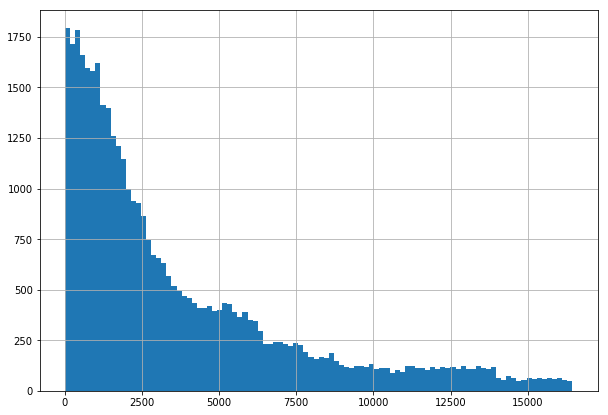

In [30]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

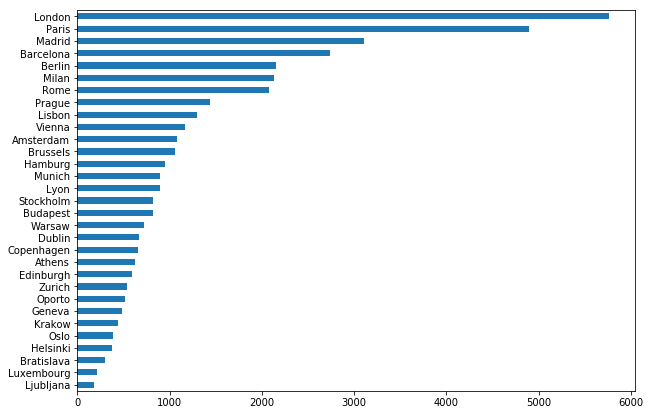

In [37]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

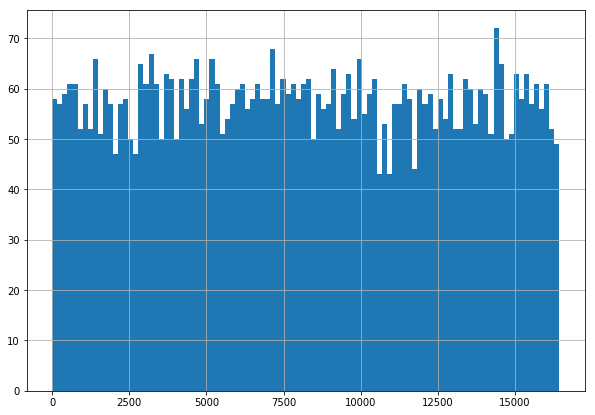

In [38]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

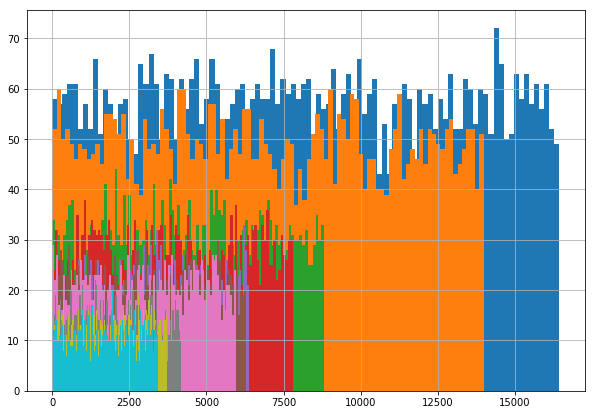

In [39]:
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

count    40000.000000
mean      3676.028525
std       3708.749567
min          1.000000
25%        973.000000
50%       2285.000000
75%       5260.000000
max      16444.000000
Name: Ranking, dtype: float64

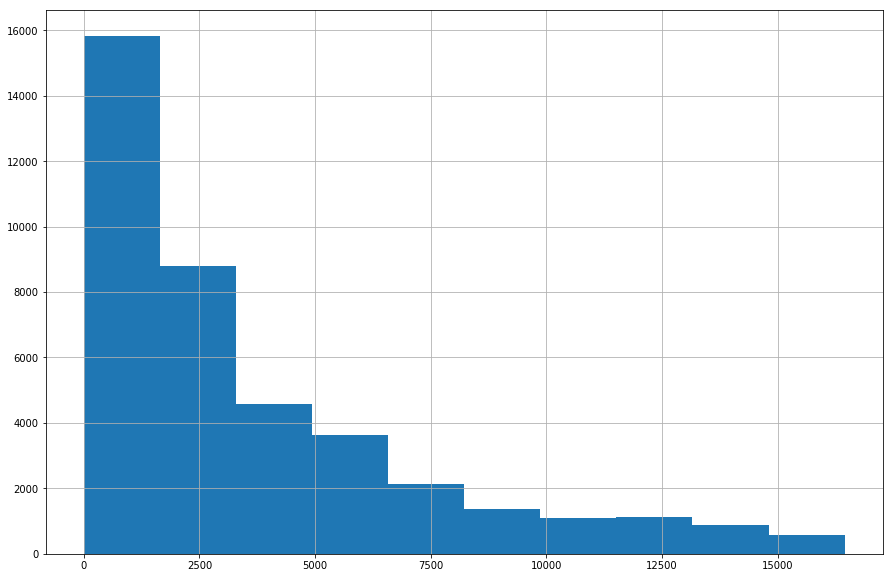

In [132]:
df_train['Ranking'].hist()
df_train['Ranking'].describe()

In [133]:
median = df_train['Ranking'].median()
IQR = df_train['Ranking'].quantile(0.75) - df_train['Ranking'].quantile(0.25)
perc25 = df_train['Ranking'].quantile(0.25)
perc75 = df_train['Ranking'].quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
#df['Ranking'].loc[df['Ranking'].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 50
#                                                                                              , range = (0, 12000), 
#                                                                                             label = 'IQR')
#df['Ranking'].loc[df['Ranking'] <= 4].hist(alpha = 0.5, bins = 50, range = (0, 45),
#                                                        label = 'Здравый смысл')
#plt.legend();

25-й перцентиль: 973.0, 75-й перцентиль: 5260.0, IQR: 4287.0,  Границы выбросов: [-5457.5, 11690.5].


In [134]:
data_city_up=df_train.loc[df_train['Ranking'] > 11690.5]
data_city_up['City'].value_counts()

London    1650
Paris      800
Name: City, dtype: int64

In [135]:
data_city_up1=df_train.loc[df_train['Ranking'] > 5260]
data_city_up1['City'].value_counts()

London       3906
Paris        3013
Madrid       1235
Barcelona     900
Berlin        387
Milan         326
Rome          232
Name: City, dtype: int64

In [136]:
data_city_down=df_train.loc[df_train['Ranking'] < 973]
data_city_down['City'].value_counts()

Athens        357
Paris         354
Krakow        351
London        345
Hamburg       343
Rome          342
Milan         342
Madrid        340
Prague        337
Zurich        336
Amsterdam     334
Lyon          333
Edinburgh     331
Oporto        331
Warsaw        330
Oslo          330
Vienna        330
Geneva        329
Budapest      329
Lisbon        329
Dublin        329
Copenhagen    328
Helsinki      326
Stockholm     322
Munich        318
Barcelona     313
Brussels      311
Bratislava    301
Berlin        296
Luxembourg    210
Ljubljana     183
Name: City, dtype: int64

In [139]:
df['Price Range'].value_counts(ascending=True)

3     1423
1     6279
2    32298
Name: Price Range, dtype: int64

In [140]:
data_pr_1=df.loc[df['Price Range'] == 1]
data_pr_1['Rating'].value_counts()

4.5    2137
4.0    1955
3.5     954
5.0     688
3.0     349
2.5     121
2.0      51
1.0      14
1.5      10
Name: Rating, dtype: int64

In [119]:
data_pr_2=df.loc[df['Price Range'] == 2]
data_pr_2['Rating'].value_counts()

4.0    11204
4.5     8172
3.5     5745
5.0     3088
3.0     2580
2.5      787
2.0      411
1.0      183
1.5      128
Name: Rating, dtype: int64

In [120]:
data_pr_3=df.loc[df['Price Range'] == 3]
data_pr_3['Rating'].value_counts()

4.5    620
4.0    533
3.5    125
5.0    103
3.0     26
2.5      7
1.0      4
2.0      4
1.5      1
Name: Rating, dtype: int64

count    37457.000000
mean       124.825480
std        295.666352
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

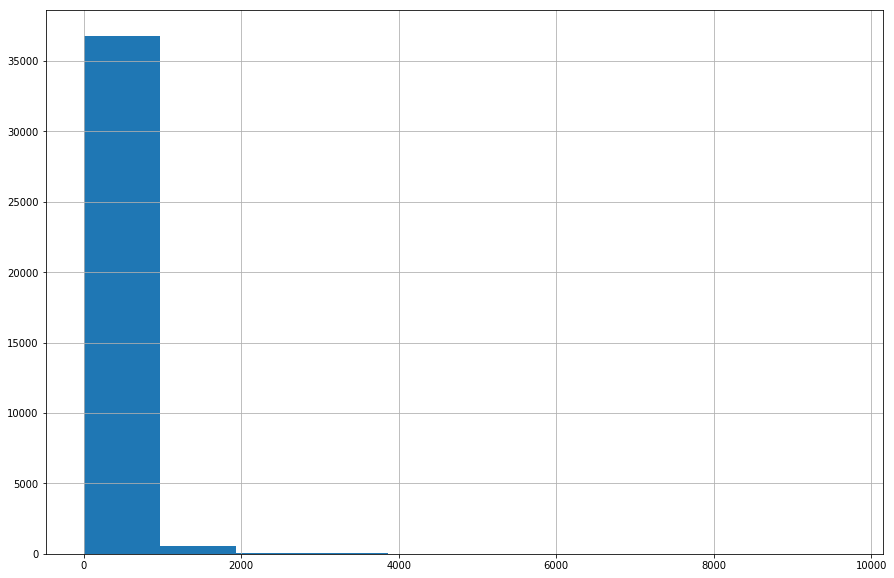

In [141]:
df_train['Number of Reviews'].hist()
df_train['Number of Reviews'].describe()

In [142]:
median = df_train['Number of Reviews'].median()
IQR = df_train['Number of Reviews'].quantile(0.75) - df_train['Number of Reviews'].quantile(0.25)
perc25 = df_train['Number of Reviews'].quantile(0.25)
perc75 = df_train['Number of Reviews'].quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25-й перцентиль: 9.0, 75-й перцентиль: 115.0, IQR: 106.0,  Границы выбросов: [-150.0, 274.0].


In [155]:
data_nor_up=df_train.loc[df_train['Number of Reviews'] > 274]
data_nor_up['Rating'].value_counts()

4.0    1927
4.5    1458
3.5     740
3.0     150
5.0      35
2.5      22
2.0      11
1.5       4
1.0       1
Name: Rating, dtype: int64

count    36206.000000
mean       142.548832
std        222.554361
min          0.000000
25%         20.000000
50%         67.000000
75%        173.000000
max       3296.000000
Name: rew_delta, dtype: float64

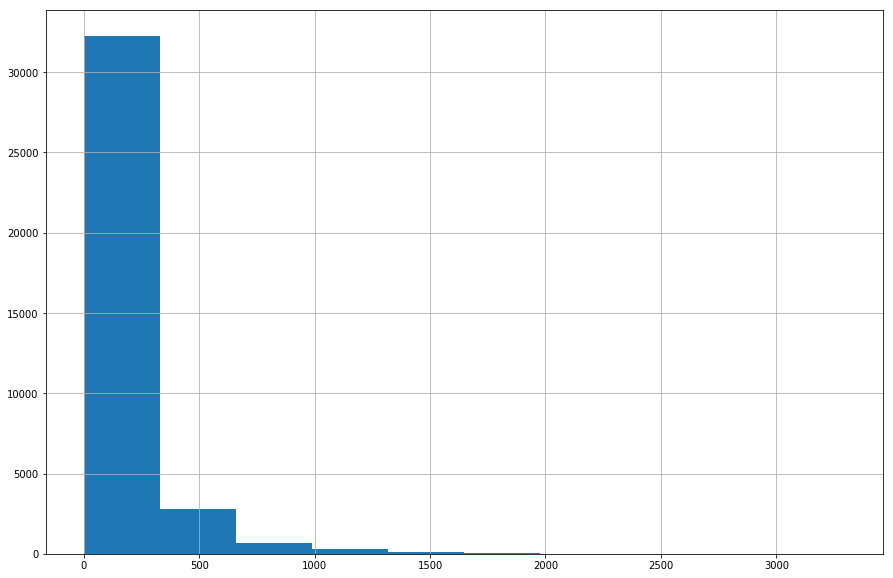

In [148]:
data['rew_delta'].hist()
data['rew_delta'].describe()

In [149]:
median = data['rew_delta'].median()
IQR = data['rew_delta'].quantile(0.75) - data['rew_delta'].quantile(0.25)
perc25 = data['rew_delta'].quantile(0.25)
perc75 = data['rew_delta'].quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25-й перцентиль: 20.0, 75-й перцентиль: 173.0, IQR: 153.0,  Границы выбросов: [-209.5, 402.5].


In [154]:
data_rd_up=data.loc[data['rew_delta'] > 402.5]
data_rd_up['Rating'].value_counts()

4.0    759
0.0    628
4.5    559
3.5    494
3.0    225
5.0    122
2.5     91
2.0     29
1.5      9
1.0      4
Name: Rating, dtype: int64

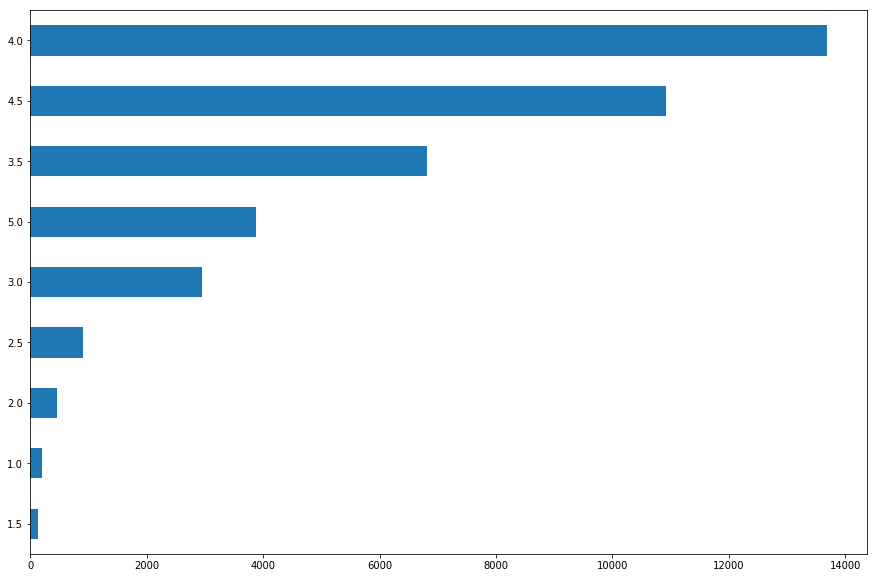

In [156]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

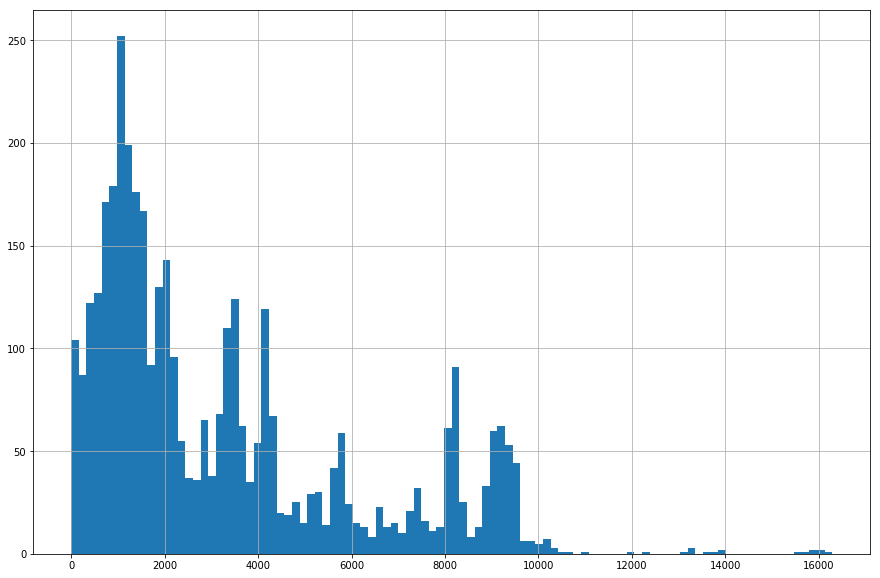

In [157]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

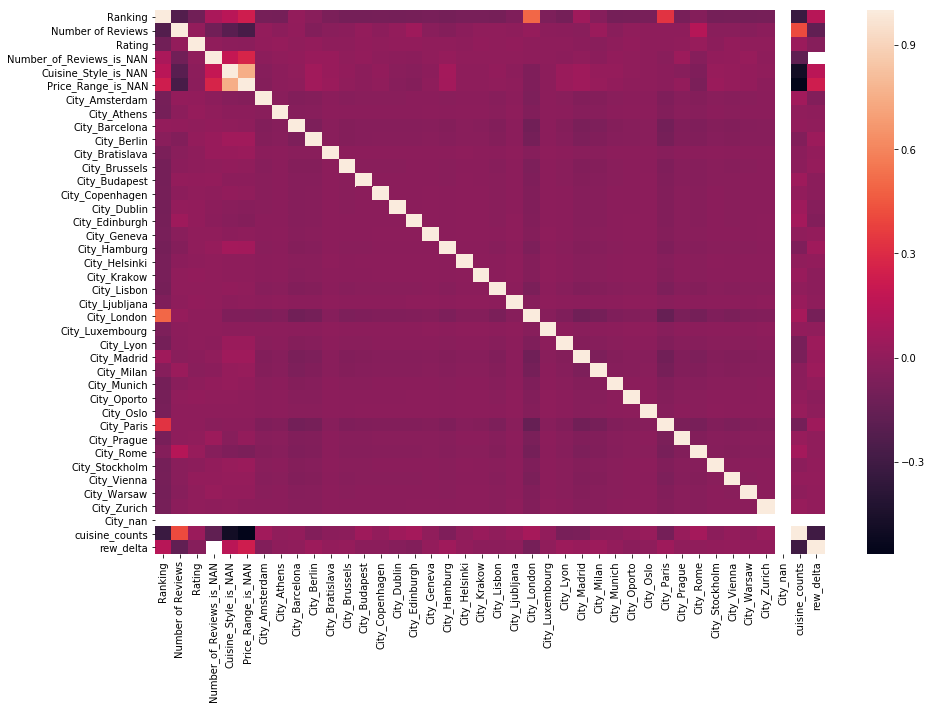

In [158]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

In [161]:
data.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)

data.drop([ 'URL_TA','Reviews','Cuisine Style'], axis = 1, inplace=True)

KeyError: "['Restaurant_id' 'ID_TA'] not found in axis"

In [162]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 45 columns):
Ranking                     50000 non-null float64
Number of Reviews           50000 non-null float64
sample                      50000 non-null int64
Rating                      50000 non-null float64
Number_of_Reviews_is_NAN    50000 non-null uint8
Cuisine_Style_is_NAN        50000 non-null uint8
Price_Range_is_NAN          50000 non-null uint8
City_Amsterdam              50000 non-null uint8
City_Athens                 50000 non-null uint8
City_Barcelona              50000 non-null uint8
City_Berlin                 50000 non-null uint8
City_Bratislava             50000 non-null uint8
City_Brussels               50000 non-null uint8
City_Budapest               50000 non-null uint8
City_Copenhagen             50000 non-null uint8
City_Dublin                 50000 non-null uint8
City_Edinburgh              50000 non-null uint8
City_Geneva                 50000 non-null uint8
Cit

In [163]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [164]:
train_data.shape, X.shape, X_train.shape, X_test.shape

((40000, 44), (40000, 43), (32000, 43), (8000, 43))

In [165]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics

In [166]:
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [167]:
model.fit(X_train, y_train)

ValueError: setting an array element with a sequence.

In [168]:
y_pred = model.predict(X_test)

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [169]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

NameError: name 'y_pred' is not defined

In [170]:
plt.rcParams['figure.figsize'] = (10,5)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [171]:
test_data = data.query('sample == 0').drop(['sample'], axis=1)
test_data = test_data.drop(['Rating'], axis=1)


In [172]:
predict_submission = model.predict(test_data)

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [173]:
predict_submission = model.predict(test_data)

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.